#Question 1
Can we predict performance for the 2024 Japanese Grand Prix using only the data from the 2023 Japanese Grand Prix?

In [ ]:
import warnings
warnings.filterwarnings('ignore')

!pip install fastf1 > /dev/null

import fastf1
from fastf1 import get_session
from fastf1.core import InvalidSessionError
from datetime import datetime

# data imports
import pandas as pd
import numpy as np
from plotnine import *

# performance
from sklearn.metrics import accuracy_score, confusion_matrix,\
 f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.calibration import calibration_curve

# modeling imports
from sklearn.linear_model import LinearRegression, LassoCV # Linear Regression Model
from sklearn.preprocessing import StandardScaler, OneHotEncoder #Z-score variables
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error #model evaluation

# model validation imports
from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv

# pipeline imports
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer

%matplotlib inline

In [ ]:
session = fastf1.get_session(2023, 'Suzuka', 'R')
session.load(telemetry=False)
weather_data = session.laps.get_weather_data()
laps = session.laps
laps = laps.reset_index(drop=True)
weather_data = weather_data.reset_index(drop=True)
japanese_gp_2023 = pd.concat([laps, weather_data.loc[:, ~(weather_data.columns == 'Time')]], axis=1)
japanese_gp_2023['Year'] = 2023
japanese_gp_2023['Event'] = session.session_info['Meeting']['Name']

session = fastf1.get_session(2024, 'Suzuka', 'R')
session.load(telemetry=False)
weather_data = session.laps.get_weather_data()
laps = session.laps
laps = laps.reset_index(drop=True)
weather_data = weather_data.reset_index(drop=True)
japanese_gp_2024 = pd.concat([laps, weather_data.loc[:, ~(weather_data.columns == 'Time')]], axis=1)
japanese_gp_2024['Year'] = 2024
japanese_gp_2024['Event'] = session.session_info['Meeting']['Name']

core           INFO 	Loading data for Japanese Grand Prix - Race [v3.3.5]
INFO:fastf1.fastf1.core:Loading data for Japanese Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core       

In [ ]:
#https://stackoverflow.com/questions/21414639/convert-timedelta-to-floating-point
def convert_timedelta_to_seconds(df):
    for column in df.select_dtypes(include=['timedelta64']):
        df[column] = df[column].dt.total_seconds()
    return df

def clean_df(race_data):
  race_data = race_data.loc[race_data['IsAccurate'] == True]
  race_data = race_data.loc[race_data['FastF1Generated'] == False]
  race_data = race_data.loc[race_data['Deleted'] == False]
  #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
  race_data = race_data.drop(columns=['LapStartDate','PitInTime', 'PitOutTime','DeletedReason','IsAccurate','FastF1Generated',
                                      'Deleted','Sector1SessionTime','Sector2SessionTime','Sector3SessionTime','LapStartTime'])
  #https://stackoverflow.com/questions/15891038/change-column-type-in-pandas
  race_data[['AirTemp', 'Humidity','Pressure','TrackTemp','WindDirection','WindSpeed']] = race_data[['AirTemp','Humidity','Pressure','TrackTemp','WindDirection','WindSpeed']].apply(pd.to_numeric)
  race_data = race_data.astype({'Rainfall': bool})

  race_data.dropna(inplace = True)

  # Convert timedelta64 columns to seconds
  race_data = convert_timedelta_to_seconds(race_data)

  return race_data


In [ ]:
japanese_gp_2023 = clean_df(japanese_gp_2023)
japanese_gp_2024 = clean_df(japanese_gp_2024)

In [ ]:
japanese_gp_2023.head(547)

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,SpeedI1,...,Position,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,Year,Event
4,4506.422,VER,1,96.748,5.0,1.0,34.900,42.960,18.888,276.0,...,1.0,27.2,43.0,1013.0,False,42.6,133,2.0,2023,Japanese Grand Prix
5,4604.259,VER,1,97.837,6.0,1.0,35.176,43.659,19.002,274.0,...,1.0,27.2,42.0,1012.9,False,43.0,130,3.0,2023,Japanese Grand Prix
6,4702.292,VER,1,98.033,7.0,1.0,35.395,43.518,19.120,277.0,...,1.0,27.1,42.0,1013.0,False,42.8,79,1.3,2023,Japanese Grand Prix
8,4898.681,VER,1,98.241,9.0,1.0,35.535,43.764,18.942,275.0,...,1.0,27.1,41.0,1012.9,False,43.0,9,1.7,2023,Japanese Grand Prix
9,4996.982,VER,1,98.301,10.0,1.0,35.544,43.760,18.997,274.0,...,1.0,27.1,40.0,1012.9,False,43.5,155,1.5,2023,Japanese Grand Prix
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,4518.964,PER,11,99.985,5.0,2.0,36.125,44.595,19.265,278.0,...,17.0,27.2,43.0,1013.0,False,42.6,133,2.0,2023,Japanese Grand Prix
863,4619.723,PER,11,100.759,6.0,2.0,36.123,45.080,19.556,277.0,...,17.0,27.2,42.0,1012.9,False,43.0,130,3.0,2023,Japanese Grand Prix
864,4719.857,PER,11,100.134,7.0,2.0,36.644,44.415,19.075,273.0,...,16.0,27.1,42.0,1013.0,False,42.8,79,1.3,2023,Japanese Grand Prix
865,4819.561,PER,11,99.704,8.0,2.0,35.974,44.497,19.233,268.0,...,16.0,27.2,41.0,1013.0,False,43.1,85,1.2,2023,Japanese Grand Prix


In [ ]:
japanese_gp_2024.head(573)

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,SpeedI1,...,Position,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,Year,Event
3,5871.980,VER,1,96.472,4.0,2.0,34.772,43.042,18.658,278.0,...,1.0,22.5,37.0,1012.2,False,39.0,216,3.1,2024,Japanese Grand Prix
4,5968.417,VER,1,96.437,5.0,2.0,34.690,43.035,18.712,279.0,...,1.0,22.5,38.0,1012.3,False,39.0,195,3.0,2024,Japanese Grand Prix
5,6065.272,VER,1,96.855,6.0,2.0,34.965,43.196,18.694,278.0,...,1.0,22.5,39.0,1012.2,False,38.8,201,3.1,2024,Japanese Grand Prix
9,6454.339,VER,1,97.590,10.0,2.0,35.450,43.353,18.787,277.0,...,1.0,22.2,39.0,1012.3,False,39.0,196,3.2,2024,Japanese Grand Prix
10,6552.113,VER,1,97.774,11.0,2.0,35.320,43.622,18.832,276.0,...,1.0,22.1,38.0,1012.3,False,38.5,199,2.6,2024,Japanese Grand Prix
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,5784.783,ZHO,24,129.289,3.0,2.0,65.121,44.909,19.259,277.0,...,16.0,22.5,36.0,1012.3,False,38.8,220,2.9,2024,Japanese Grand Prix
896,5885.011,ZHO,24,100.228,4.0,2.0,36.656,44.602,18.970,272.0,...,16.0,22.5,37.0,1012.2,False,39.0,216,3.1,2024,Japanese Grand Prix
897,5984.608,ZHO,24,99.597,5.0,2.0,36.238,44.522,18.837,273.0,...,16.0,22.5,38.0,1012.3,False,39.0,195,3.0,2024,Japanese Grand Prix
898,6084.599,ZHO,24,99.991,6.0,2.0,36.364,44.705,18.922,267.0,...,16.0,22.4,40.0,1012.2,False,38.8,201,2.8,2024,Japanese Grand Prix


In [ ]:
japanese_gp_2023.describe()

,Time,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,SpeedI1,SpeedI2,SpeedFL,SpeedST,TyreLife,Position,AirTemp,Humidity,Pressure,TrackTemp,WindDirection,WindSpeed,Year
count,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.0
mean,6792.810412,98.771599,27.604736,2.296903,35.762129,43.958554,19.050916,274.245902,299.442623,255.078324,297.078324,10.244080,8.495446,27.260291,42.400729,1012.854827,39.868670,123.424408,1.426230,2023.0
std,1465.152006,1.679917,14.656357,0.833387,0.602767,1.112892,0.383154,3.671205,2.696795,5.191872,5.668718,5.638323,4.775859,0.102828,2.160461,0.110735,2.671136,71.163020,0.536517,0.0
min,4506.422000,94.183000,5.000000,1.000000,33.720000,42.118000,18.345000,262.000000,284.000000,147.000000,251.000000,2.000000,1.000000,27.000000,39.000000,1012.700000,36.300000,3.000000,0.500000,2023.0
25%,5553.081000,97.860000,15.000000,2.000000,35.352000,43.560000,18.873000,272.000000,298.000000,254.000000,295.000000,6.000000,4.000000,27.200000,41.000000,1012.700000,37.300000,85.000000,1.000000,2023.0
50%,6749.720000,98.643000,27.000000,2.000000,35.725000,43.888000,19.023000,275.000000,299.000000,255.000000,298.000000,9.000000,8.000000,27.300000,42.000000,1012.900000,39.100000,114.000000,1.300000,2023.0
75%,8103.674000,99.752000,41.000000,3.000000,36.231000,44.287000,19.169000,277.000000,301.000000,257.000000,300.000000,14.000000,12.000000,27.300000,44.000000,1012.900000,42.800000,140.000000,1.700000,2023.0
max,9325.743000,122.755000,53.000000,4.000000,37.636000,66.534000,24.460000,283.000000,314.000000,266.000000,312.000000,29.000000,20.000000,27.500000,47.000000,1013.000000,43.500000,353.000000,3.000000,2023.0


In [ ]:
japanese_gp_2024.describe()

,Time,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,SpeedI1,SpeedI2,SpeedFL,SpeedST,TyreLife,Position,AirTemp,Humidity,Pressure,TrackTemp,WindDirection,WindSpeed,Year
count,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.0
mean,8220.249077,97.867392,27.627178,3.137631,35.663821,43.456085,18.747486,276.280488,298.808362,256.120209,297.317073,10.442509,9.135889,21.081707,46.400697,1012.551045,35.256620,184.533101,2.391986,2024.0
std,1458.939032,4.392838,14.801786,0.852189,3.955283,0.700087,0.304832,5.341700,3.432958,3.039216,6.351031,6.192886,4.880313,0.835719,5.863461,0.231221,2.263771,18.651431,0.684767,0.0
min,5782.836000,93.841000,3.000000,2.000000,33.310000,42.033000,18.189000,205.000000,267.000000,239.000000,219.000000,2.000000,1.000000,19.600000,36.000000,1012.100000,31.300000,135.000000,0.900000,2024.0
25%,6978.813500,96.267500,15.000000,2.000000,34.749750,42.900750,18.554500,274.000000,297.000000,254.000000,296.000000,5.000000,5.000000,20.400000,41.000000,1012.300000,33.300000,173.000000,2.000000,2024.0
50%,8200.068000,97.453000,27.000000,3.000000,35.262500,43.432000,18.720500,277.000000,299.000000,256.000000,298.000000,9.000000,9.000000,21.200000,47.000000,1012.500000,35.200000,188.000000,2.300000,2024.0
75%,9508.402250,98.618500,41.000000,4.000000,35.780500,43.940750,18.876500,279.000000,301.000000,258.000000,300.000000,14.000000,13.000000,21.575000,52.000000,1012.800000,36.500000,197.000000,2.900000,2024.0
max,10679.455000,148.991000,53.000000,5.000000,85.037000,45.219000,20.782000,285.000000,309.000000,267.000000,309.000000,30.000000,18.000000,22.500000,56.000000,1012.900000,39.000000,220.000000,4.100000,2024.0


In [ ]:
japanese_gp = pd.concat([japanese_gp_2023, japanese_gp_2024])

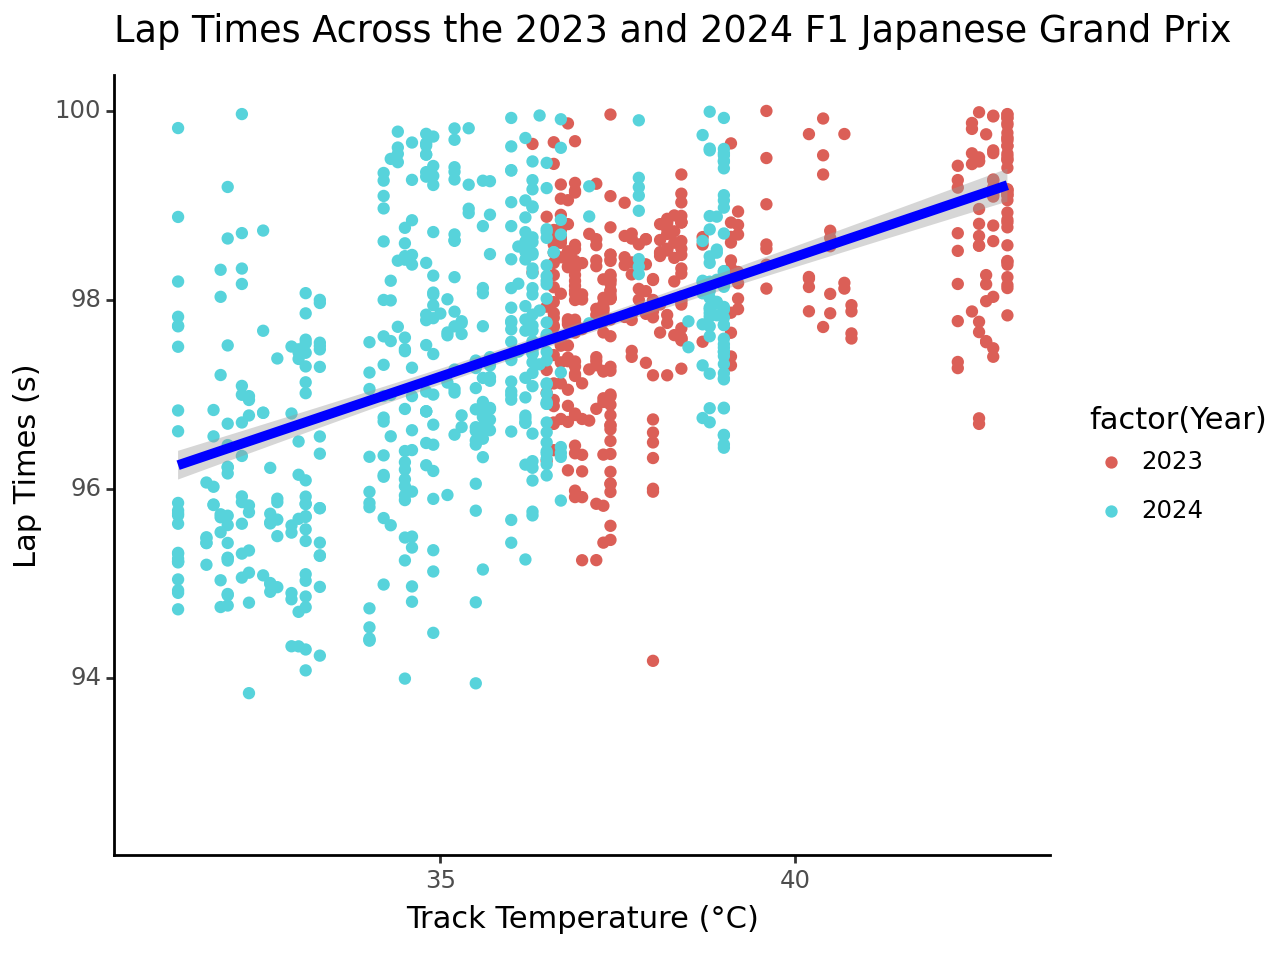

<Figure Size: (640 x 480)>

In [ ]:
(ggplot(japanese_gp, aes(x='TrackTemp', y='LapTime', color = 'factor(Year)')) +
 geom_point() +
  labs(title = 'Lap Times Across the 2023 and 2024 F1 Japanese Grand Prix',
      x = 'Track Temperature (°C)',
      y = 'Lap Times (s)') +
 geom_smooth(method = 'lm', se = True, color = 'blue', size = 2) +
 xlim(31,43) +
 ylim(92.5,100) +
 theme_classic())

In [ ]:
#Separate Data into predictors and outcome
predictors = ['Time', 'Driver', 'DriverNumber', 'LapNumber', 'Stint',
              'Sector1Time', 'Sector2Time', 'Sector3Time','SpeedI1', 'SpeedI2',
              'SpeedFL', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife',
              'FreshTyre', 'Team', 'TrackStatus', 'Position',
              'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp',
              'WindDirection', 'WindSpeed']

continuous = ['Sector1Time','Sector1Time', 'Sector2Time', 'Sector3Time', 'SpeedI1',
              'SpeedI2','SpeedFL', 'SpeedST','TyreLife','AirTemp', 'Humidity',
              'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed']

categorical = ['Time','Driver','DriverNumber','LapNumber','Stint','IsPersonalBest',
               'Compound','FreshTyre','Team','TrackStatus','Position']
outcome = ['LapTime']

x = japanese_gp_2023[predictors]

y_2023 = japanese_gp_2023[outcome]
y_2024 = japanese_gp_2024[outcome]

#TTS
# x_train, x_test, y_train, y_test = train_test_split(x, , test_size = 0.3, random_state = 42)

In [ ]:
#Empty Model
pre = make_column_transformer((StandardScaler(), continuous),
                            (OneHotEncoder(handle_unknown='ignore'), categorical),
                            remainder = 'passthrough')

#Linear Regression
lr = LinearRegression()

pipe = Pipeline([('pre', pre), ('linear', lr)])

#Fit
pipe.fit(x, y_2023)

y_pred_2023 = pipe.predict(japanese_gp_2023[predictors])
y_pred_2024 = pipe.predict(japanese_gp_2024[predictors])


print('Train MSE  : ', mean_squared_error(y_2023,y_pred_2023))
print('Train MAE  : ', mean_absolute_error(y_2023,y_pred_2023))
print('Train MAPE : ', mean_absolute_percentage_error(y_2023,y_pred_2023))
print('Train R2  : ', r2_score(y_2023,y_pred_2023))
print()
print('Test MSE  : ', mean_squared_error(y_2024,y_pred_2024))
print('Test MAE  : ', mean_absolute_error(y_2024,y_pred_2024))
print('Test MAPE : ', mean_absolute_percentage_error(y_2024,y_pred_2024))
print('Test R2  : ', r2_score(y_2024,y_pred_2024))

Train MSE  :  9.24890541776849e-11
Train MAE  :  7.640473423415946e-06
Train MAPE :  7.722713625006928e-08
Train R2  :  0.9999999999671673

Test MSE  :  0.0011828715739081108
Test MAE  :  0.023699127591595464
Test MAPE :  0.00023986268972415556
Test R2  :  0.999938594903639


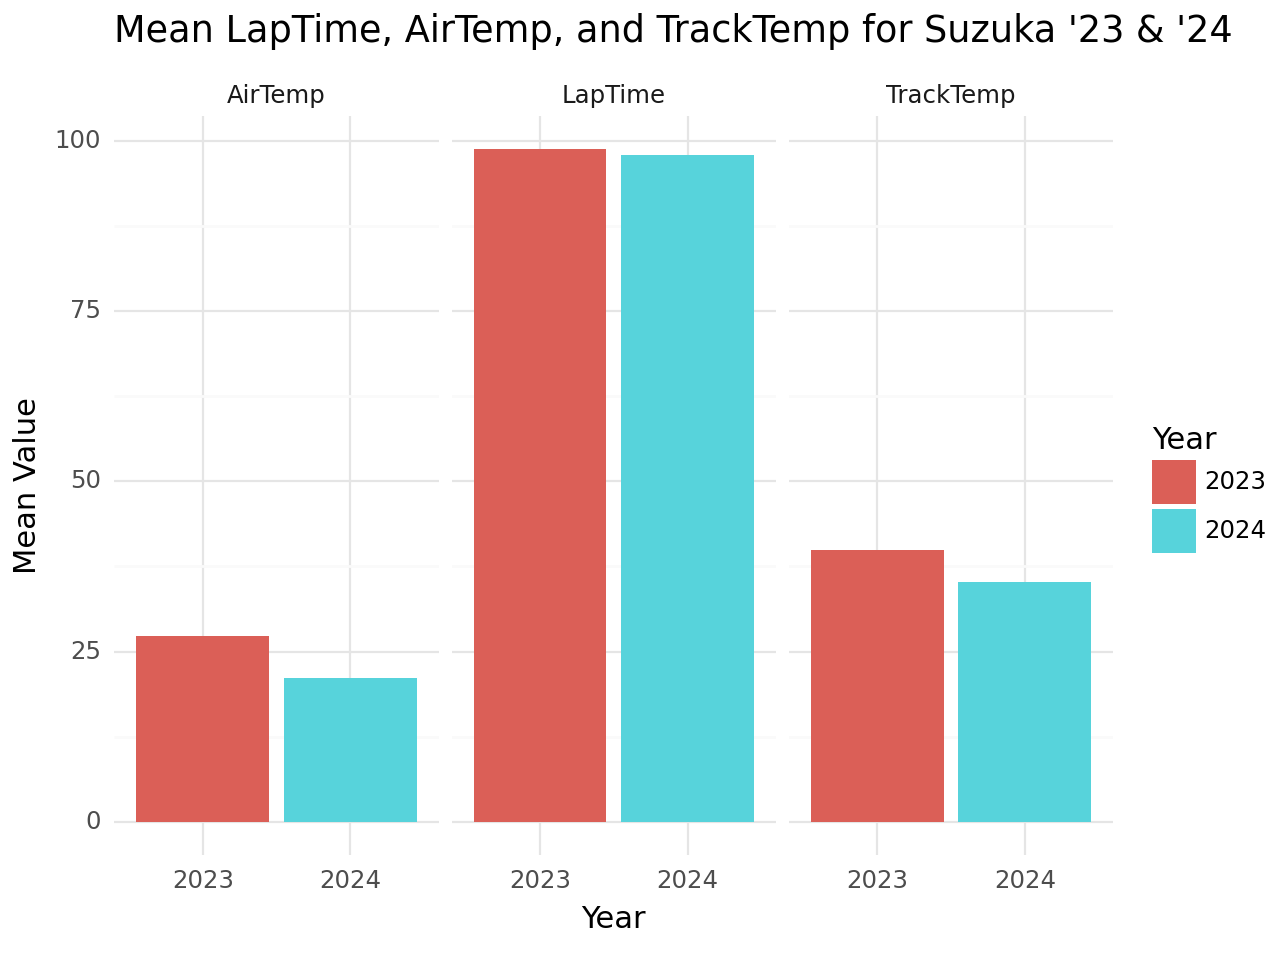

<Figure Size: (640 x 480)>

In [ ]:
#this was so hard to figure out
mean_values_2023 = japanese_gp_2023.describe().loc['mean', ['LapTime', 'AirTemp', 'TrackTemp']]
mean_values_2024 = japanese_gp_2024.describe().loc['mean', ['LapTime', 'AirTemp', 'TrackTemp']]

mean_df = pd.DataFrame({
    'Metric': ['LapTime', 'AirTemp', 'TrackTemp'] * 2,
    'Year': ['2023'] * 3 + ['2024'] * 3,
    'Mean': list(mean_values_2023) + list(mean_values_2024)
})

#https://ggplot2.tidyverse.org/reference/geom_bar.html
#https://ggplot2.tidyverse.org/reference/layer_positions.html
(ggplot(mean_df, aes(x='Year', y='Mean', fill='Year'))
+ geom_bar(stat='identity', position='dodge')
+ facet_wrap('Metric')
+ theme_minimal()
+ labs(title='Mean LapTime, AirTemp, and TrackTemp for Suzuka \'23 & \'24',
        x='Year', y='Mean Value'))

#Question 3
Does weather really play as big of a factor as other features such as drivers, cars, teams etc.?

In [ ]:
#Empty Model
pre = make_column_transformer((StandardScaler(), continuous),
                            (OneHotEncoder(handle_unknown='ignore'), categorical),
                            remainder = 'passthrough')

#Linear Regression
lasso = LassoCV()

pipe = Pipeline([('pre', pre), ('lasso', lasso)])

#Fit
pipe.fit(x, y_2023)

y_pred_2023 = pipe.predict(japanese_gp_2023[predictors])
y_pred_2024 = pipe.predict(japanese_gp_2024[predictors])


print('Train MSE  : ', mean_squared_error(y_2023,y_pred_2023))
print('Train MAE  : ', mean_absolute_error(y_2023,y_pred_2023))
print('Train MAPE : ', mean_absolute_percentage_error(y_2023,y_pred_2023))
print('Train R2  : ', r2_score(y_2023,y_pred_2023))
print()
print('Test MSE  : ', mean_squared_error(y_2024,y_pred_2024))
print('Test MAE  : ', mean_absolute_error(y_2024,y_pred_2024))
print('Test MAPE : ', mean_absolute_percentage_error(y_2024,y_pred_2024))
print('Test R2  : ', r2_score(y_2024,y_pred_2024))

Train MSE  :  3.7838006631766865e-06
Train MAE  :  0.0013506388249169795
Train MAPE :  1.3603881684941719e-05
Train R2  :  0.9999986567882244

Test MSE  :  2.8475961903943417e-05
Test MAE  :  0.0026362954341780645
Test MAPE :  2.5838414301817895e-05
Test R2  :  0.9999985217590622


In [ ]:
pipe.named_steps['lasso'].alpha_

0.0015064935967554398

In [ ]:
penalties = pipe.named_steps['lasso'].coef_

In [ ]:
d = {}
for i in range(26):
  d[predictors[i]] = penalties[i]
d
coefficients = pd.DataFrame(list(d.items()), columns=['Predictor', 'Coefficient'])
coefficients

,Predictor,Coefficient
0,Time,0.601509
1,Driver,0.000000
2,DriverNumber,1.110996
3,LapNumber,0.381878
4,Stint,-0.000000
5,Sector1Time,-0.000000
6,Sector2Time,-0.000000
7,Sector3Time,-0.000000
8,SpeedI1,0.000000
9,SpeedI2,-0.000000


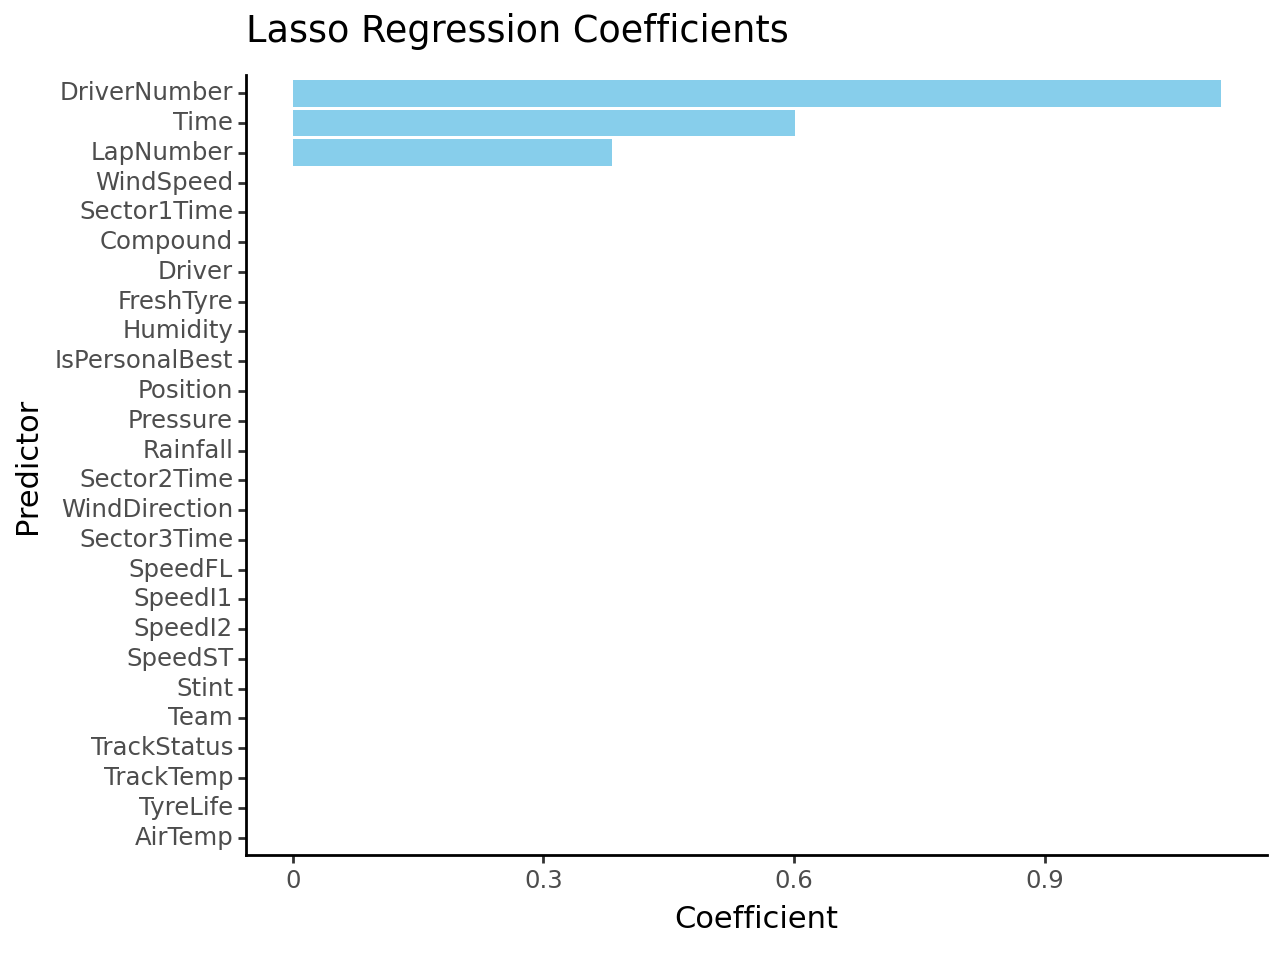

<Figure Size: (640 x 480)>

In [ ]:
#https://stackoverflow.com/questions/25664007/reorder-bars-in-geom-bar-ggplot2-by-value
(ggplot(coefficients, aes(x='reorder(Predictor, Coefficient)', y='Coefficient')) +
 geom_bar(stat='identity', fill='skyblue') +
 coord_flip() +
 theme_classic() +
 labs(title='Lasso Regression Coefficients',
      x='Predictor',
      y='Coefficient'))